In [1]:
""" 
# install software
!pip uninstall -y tensorflow
!pip install 'h5py<3.0.0'
!pip install scipy==1.1.0
#!pip install 'tensorflow-gpu==1.15.2'
!pip install 'tensorflow==1.15.2'
!pip install 'keras==2.2.4'
!pip install git+https://github.com/raghakot/keras-vis.git 
"""

" \n# install software\n!pip uninstall -y tensorflow\n!pip install 'h5py<3.0.0'\n!pip install scipy==1.1.0\n#!pip install 'tensorflow-gpu==1.15.2'\n!pip install 'tensorflow==1.15.2'\n!pip install 'keras==2.2.4'\n!pip install git+https://github.com/raghakot/keras-vis.git \n"

In [2]:
# Mount Google Drive and Access Data
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
# # Move to the target folder
# %cd /content/drive/MyDrive/XPCS/Resnet50_s257_zero11x11_new

In [4]:
import ast
import glob
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
from utils import resnet
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing import image
from matplotlib.font_manager import _rebuild

Using TensorFlow backend.
/Users/mingrenshen/anaconda3/envs/BleedingSites/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mingrenshen/anaconda3/envs/BleedingSites/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mingrenshen/anaconda3/envs/BleedingSites/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint1

# New Section

In [5]:
batch_size = 40 
nb_classes = 19
nb_img_per_class = 1000
nb_epoch = 2
data_augmentation = True

# input image dimensions
img_rows, img_cols = 257, 257
# The images are duplicated to fit RGB channels.
img_channels = 3

In [6]:
model = resnet.ResnetBuilder.build_resnet_50((img_channels, img_rows, img_cols), nb_classes)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 257, 257, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 129, 129, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 129, 129, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 129, 129, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [7]:
# loading weights of the trained model
from keras.models import model_from_json
# load json and create model
json_file = open('saved/model_structure.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved/model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [8]:
Xtest = np.load("X_test.npy")
Ytest = np.load("y_gt_test.npy")
Ypred = np.load("y_pred_test_raw.npy")

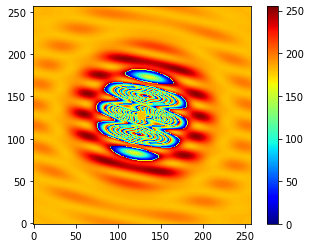

0


In [9]:
# Plot example
img0 = (Xtest[0][:,:,1]* 255).astype(np.uint8)
plt.imshow(img0, origin="lower", cmap='jet')
plt.colorbar()
plt.show()
print(Ytest[0])

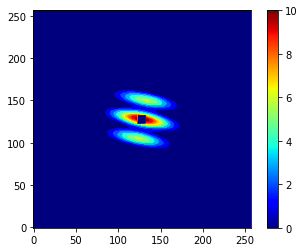

0


In [10]:
# Plot example
img0 = (Xtest[0][:,:,1]).astype(np.uint8)
plt.imshow(img0, origin="lower", cmap='jet')
plt.colorbar()
plt.show()
print(Ytest[0])

In [11]:
Xtest[0].shape

(257, 257, 3)

In [12]:
from vis.utils import utils
from keras.activations import linear
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx =  -1
# Swap softmax with linear
loaded_model.layers[layer_idx].activation = linear
loaded_model = utils.apply_modifications(loaded_model)

/Users/mingrenshen/anaconda3/envs/BleedingSites/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [13]:
from vis.visualization import visualize_cam

penultimate_layer_idx = utils.find_layer_idx(loaded_model, "conv2d_53") 
class_idx  = Ytest[0]
seed_input = Xtest[0]
grad_top1  = visualize_cam(loaded_model, layer_idx, class_idx, seed_input, 
                           penultimate_layer_idx = penultimate_layer_idx,
                           backprop_modifier     = None,
                           grad_modifier         = None)

In [14]:
# generating class labels
classlabel = []
for ii in range(nb_classes):
    if ii+2 < 10:
        classlabel.append("Beads_0" + str(ii+2))
    else:
        classlabel.append("Beads_" + str(ii+2))

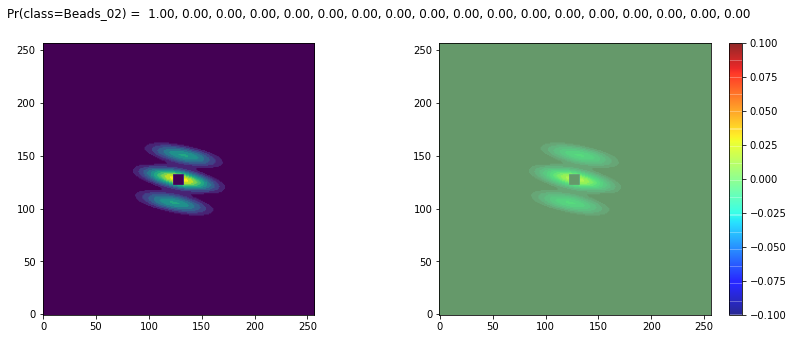

In [15]:
def plot_map(grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(img0, origin="lower", cmap='viridis')
    axes[1].imshow(img0, origin="lower", cmap='viridis')
    i = axes[1].imshow(grads,cmap="jet",alpha=0.6,origin="lower")
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f}".format(classlabel[class_idx],Ypred[0][0], Ypred[0][1],Ypred[0][2],Ypred[0][3],Ypred[0][4],Ypred[0][5],Ypred[0][6],Ypred[0][7],Ypred[0][8],Ypred[0][9],Ypred[0][10],Ypred[0][11],Ypred[0][12],Ypred[0][13],Ypred[0][14],Ypred[0][15],Ypred[0][16],Ypred[0][17],Ypred[0][18]))
plot_map(grad_top1)

In [16]:
np.argmax(Ypred[0])

0

In [17]:
""" 
for i in range(1900):
    if i% 10 == 0:
        print(i)
    class_idx  = Ytest[i]
    seed_input = Xtest[i]
    grad_top1  = visualize_cam(loaded_model, layer_idx, class_idx, seed_input, 
                               penultimate_layer_idx = penultimate_layer_idx,#None,
                               backprop_modifier     = None,
                               grad_modifier         = None)
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow((seed_input[:,:,1]).astype(np.uint8), origin="lower", cmap='viridis')
    axes[1].imshow((seed_input[:,:,1]).astype(np.uint8), origin="lower", cmap='viridis')
    img = axes[1].imshow(grad_top1,cmap="jet",origin="lower",alpha=0.6)
    fig.colorbar(img)
    plt.suptitle("Pr(class={},pred={}) = {:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f}".format(
                      classlabel[class_idx],classlabel[np.argmax(Ypred[i])],
                      Ypred[i][0], Ypred[i][1],Ypred[i][2],Ypred[i][3],Ypred[i][4],Ypred[i][5],Ypred[i][6],Ypred[i][7],Ypred[i][8],Ypred[i][9],Ypred[i][10],Ypred[i][11],Ypred[i][12],Ypred[i][13],Ypred[i][14],Ypred[i][15],Ypred[i][16],Ypred[i][17],Ypred[i][18]))
    plt.savefig("NEW_CAM/CAM_TrueClass_"+str(classlabel[class_idx])+"_Pred_"+str(np.argmax(Ypred[i]))+"_index_"+str(i)+".jpg",dpi=300)
    plt.close() 
    """

' \nfor i in range(1900):\n    if i% 10 == 0:\n        print(i)\n    class_idx  = Ytest[i]\n    seed_input = Xtest[i]\n    grad_top1  = visualize_cam(loaded_model, layer_idx, class_idx, seed_input, \n                               penultimate_layer_idx = penultimate_layer_idx,#None,\n                               backprop_modifier     = None,\n                               grad_modifier         = None)\n    fig, axes = plt.subplots(1,2,figsize=(14,5))\n    axes[0].imshow((seed_input[:,:,1]).astype(np.uint8), origin="lower", cmap=\'viridis\')\n    axes[1].imshow((seed_input[:,:,1]).astype(np.uint8), origin="lower", cmap=\'viridis\')\n    img = axes[1].imshow(grad_top1,cmap="jet",origin="lower",alpha=0.6)\n    fig.colorbar(img)\n    plt.suptitle("Pr(class={},pred={}) = {:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f}".format(\n                      classlabel[class_idx],classlabel[np.

## Saliency Maps

Detailed Doucment of Saliency Maps could be found here, [Saliency Maps](https://raghakot.github.io/keras-vis/visualizations/saliency/). Below is a brief summary of what is saliency map and what we want to do. 

> The idea behind saliency is pretty simple in hindsight. We compute the gradient of output category with respect to 
input image. 

> $$\frac{\partial output}{\partial input}$$

> This should tell us how the output value changes with respect to a small change in inputs. We can use these gradients 
to highlight input regions that cause the most change in the output. Intuitively this should highlight salient image 
regions that most contribute towards the output.

Example iPython notebook is [Attention on ResNet50 (Saliency and grad-CAM)](https://github.com/raghakot/keras-vis/blob/master/examples/resnet/attention.ipynb)

In [18]:
# import packages
# some packages needed to be run before this section and run Grad-CAM first
from vis.visualization import visualize_saliency, overlay
#from vis.utils import utils
from keras import activations

In [19]:
for i in range(1875,1900):
    if i% 25 == 0:
        print(i)
    class_idx  = Ytest[i]
    seed_input = Xtest[i]
    #modifiers = ['guided']
    #sub_titles = ['Guided Saliency']

    # plot CAM plots

    # X-ray Speckle Pattern
    fig, axes = plt.subplots(1,3,figsize=(18,5))
    axes[0].imshow((seed_input[:,:,1]).astype(np.uint8), origin="lower", cmap='viridis')
    axes[0].title.set_text('X-ray Speckle Pattern')

    # Plain Saliency Maps
    # class_idx is the beads number index of predication
    grads = visualize_saliency(loaded_model, layer_idx, filter_indices=class_idx, seed_input = seed_input)
    # Lets overlay the heatmap onto original image.    
    axes[1].imshow(grads, origin="lower", cmap='jet')
    axes[1].title.set_text('Saliency Maps')
    #for j in range(len(modifiers)):

    # 'guided' Saliency Maps
    # class_idx is the beads number index of predication
    grads = visualize_saliency(loaded_model, layer_idx, filter_indices=class_idx, seed_input = seed_input, backprop_modifier='guided')
    # Lets overlay the heatmap onto original image.    
    axes[2].imshow(grads, origin="lower", cmap='jet')
    axes[2].title.set_text('Guided Saliency')
    
    plt.suptitle("Pr(class={},pred={}) = {:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f},{:5.2f}".format(
                      classlabel[class_idx],classlabel[np.argmax(Ypred[i])],
                      Ypred[i][0], Ypred[i][1],Ypred[i][2],Ypred[i][3],Ypred[i][4],Ypred[i][5],Ypred[i][6],Ypred[i][7],Ypred[i][8],Ypred[i][9],Ypred[i][10],Ypred[i][11],Ypred[i][12],Ypred[i][13],Ypred[i][14],Ypred[i][15],Ypred[i][16],Ypred[i][17],Ypred[i][18]))
    plt.savefig("Saliency/Saliency_TrueClass_"+str(classlabel[class_idx])+"_Pred_"+str(np.argmax(Ypred[i]))+"_index_"+str(i)+".jpg",dpi=300)
    plt.close(fig)
    plt.cla()
    plt.clf()
    plt.close('all')
    

1875
